# Match predicter for national football

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

#import
df = pd.read_csv('results.csv')
df
df.shape

(48366, 9)

In [70]:
#filtering
'''
uncomment if only important tournaments to use
rel_tournaments = [
    'FIFA World Cup',
    'UEFA Nations League',
    'UEFA Euro',
    'AFC Asian Cup',
    'African Cup of Nations',
    'Gold Cup',
    'Copa América',
    'Oceania Nations Cup'
]

df_filtered = df[df['tournament'].isin(rel_tournaments)].copy() #why copy?
'''
#check for null values and duplicates:
df.dropna(inplace=True)
df.drop_duplicates()
print(df.shape)

df_filtered = df[['date','home_team','away_team','home_score','away_score','tournament']].copy()

df_filtered.shape


(48366, 9)


(48366, 6)

In [71]:
#print first lines
print(df_filtered.head())

         date home_team away_team  home_score  away_score tournament
0  1872-11-30  Scotland   England           0           0   Friendly
1  1873-03-08   England  Scotland           4           2   Friendly
2  1874-03-07  Scotland   England           2           1   Friendly
3  1875-03-06   England  Scotland           2           2   Friendly
4  1876-03-04  Scotland   England           3           0   Friendly


## create pred. var


In [72]:
def determineResult(row):
    if row['home_score'] > row['away_score']:
        return 'H'  # Home won
    elif row['home_score'] < row['away_score']:
        return 'A'  # Away won
    else:
        return 'D'  # tie

df_filtered['result'] = df_filtered.apply(determineResult, axis=1)

## Prepare train test data

In [73]:
#simple feature engineering
le = LabelEncoder()
all_teams = pd.concat([df_filtered['home_team'], df_filtered['away_team']]).unique()
le.fit(all_teams)

df_filtered['home_id'] = le.transform(df_filtered['home_team'])
df_filtered['away_id'] = le.transform(df_filtered['away_team'])

#create ids
tournament_encoder = LabelEncoder()
df_filtered['tournament_id'] = tournament_encoder.fit_transform(df_filtered['tournament'])

features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

df_filtered

,date,home_team,away_team,home_score,away_score,tournament,result,home_id,away_id,tournament_id
0,1872-11-30,Scotland,England,0,0,Friendly,D,252,90,89
1,1873-03-08,England,Scotland,4,2,Friendly,H,90,252,89
2,1874-03-07,Scotland,England,2,1,Friendly,H,252,90,89
3,1875-03-06,England,Scotland,2,2,Friendly,D,90,252,89
4,1876-03-04,Scotland,England,3,0,Friendly,H,252,90,89
...,...,...,...,...,...,...,...,...,...,...
48361,2025-06-29,Canada,Guatemala,1,1,Gold Cup,D,48,120,91
48362,2025-06-29,United States,Costa Rica,2,2,Gold Cup,D,306,68,91
48363,2025-07-02,United States,Guatemala,2,1,Gold Cup,H,306,120,91
48364,2025-07-02,Mexico,Honduras,1,0,Gold Cup,H,183,129,91


## train model:

In [74]:
#split data
X = df_filtered[features]
y = df_filtered[target]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
#actual model training
model_RF = RandomForestClassifier(n_estimators=300, random_state=42,min_samples_split=2)

model_RF.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [76]:
#import joblib
#save model
#joblib.dump(model_RF, 'random_forest_model.pkl')


## Now XGBoost model for prediction

In [77]:
#prepare data again:
le = LabelEncoder()
df_filtered['result_encoded'] = le.fit_transform(df_filtered['result'])

y = df_filtered['result_encoded']

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Klassen-Mapping:", class_mapping)

features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

X = df_filtered[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Klassen-Mapping: {'A': np.int64(0), 'D': np.int64(1), 'H': np.int64(2)}


In [78]:
#create model:
model_XGB = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50
)
print("DEBUG")
# Modell trainieren mit Validation Set für early stopping
model_XGB.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50  # Zeigt alle 50 Runden den Fortschritt
)

DEBUG
[0]	validation_0-mlogloss:1.09363
[50]	validation_0-mlogloss:1.02191
[100]	validation_0-mlogloss:1.00663
[150]	validation_0-mlogloss:0.99649
[200]	validation_0-mlogloss:0.98992
[250]	validation_0-mlogloss:0.98503
[300]	validation_0-mlogloss:0.98124
[350]	validation_0-mlogloss:0.97879
[400]	validation_0-mlogloss:0.97646
[450]	validation_0-mlogloss:0.97474
[500]	validation_0-mlogloss:0.97340
[550]	validation_0-mlogloss:0.97234
[600]	validation_0-mlogloss:0.97160
[650]	validation_0-mlogloss:0.97131
[700]	validation_0-mlogloss:0.97095
[734]	validation_0-mlogloss:0.97095


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


## evaluation of the models

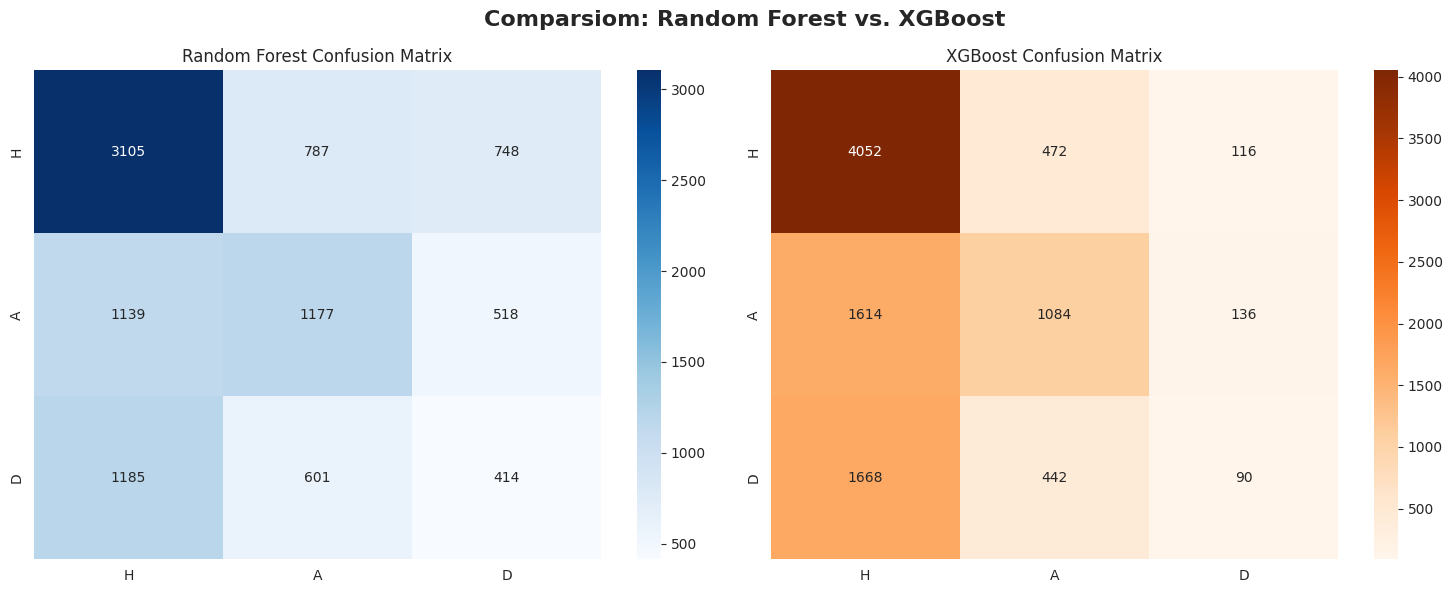

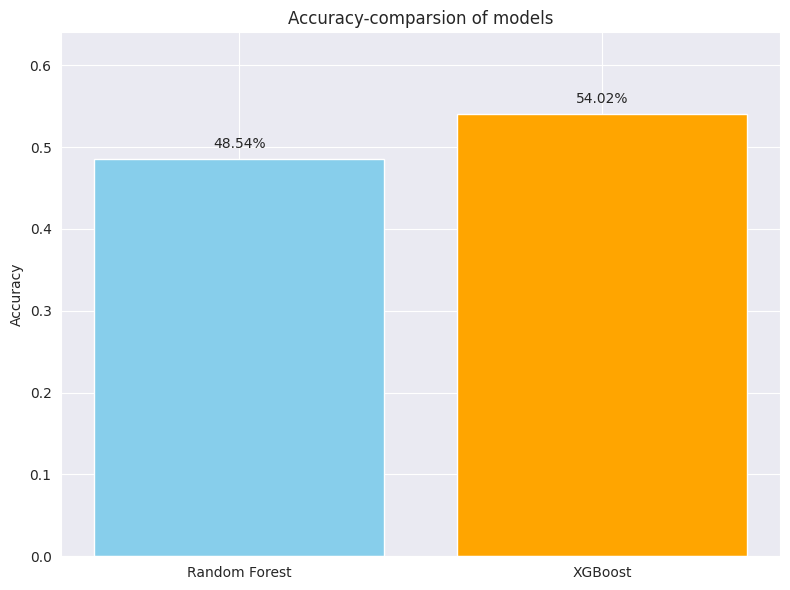

In [79]:
#code variables from int to string back
y_test_decoded = le.inverse_transform(y_test)

y_pred_rf = model_RF.predict(X_test)
y_pred_XGB = model_XGB.predict(X_test)

y_pred_XGB = le.inverse_transform(y_pred_XGB)

acc_rf = accuracy_score(y_test_decoded, y_pred_rf)
acc_XGB = accuracy_score(y_test_decoded, y_pred_XGB)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparsiom: Random Forest vs. XGBoost', fontsize=16, fontweight='bold')

#Confusion Matrix of Random Forest
cm_rf = confusion_matrix(y_test_decoded, y_pred_rf, labels=['H', 'A', 'D'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['H', 'A', 'D'], yticklabels=['H', 'A', 'D'])
axes[0].set_title('Random Forest Confusion Matrix')

#Confusion Matrix of XGBoost
cm_log = confusion_matrix(y_test_decoded, y_pred_XGB, labels=['H', 'A', 'D'])
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
           xticklabels=['H', 'A', 'D'], yticklabels=['H', 'A', 'D'])
axes[1].set_title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.show()

#evaluate accuary
plt.figure(figsize=(8, 6))
models = ['Random Forest', 'XGBoost']
accuracies = [acc_rf, acc_XGB]

bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.title('Accuracy-comparsion of models')
plt.ylabel('Accuracy')
plt.ylim(0, max(accuracies) + 0.1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [81]:
print('Classification Reports:')
print('Random forest:')
print(classification_report(y_test_decoded, y_pred_rf, zero_division=0))
print('XGBoost:')
print(classification_report(y_test_decoded, y_pred_XGB, zero_division=0))

Classification Reports:
Random forest:
              precision    recall  f1-score   support

           A       0.46      0.42      0.44      2834
           D       0.25      0.19      0.21      2200
           H       0.57      0.67      0.62      4640

    accuracy                           0.49      9674
   macro avg       0.43      0.42      0.42      9674
weighted avg       0.46      0.49      0.47      9674

XGBoost:
              precision    recall  f1-score   support

           A       0.54      0.38      0.45      2834
           D       0.26      0.04      0.07      2200
           H       0.55      0.87      0.68      4640

    accuracy                           0.54      9674
   macro avg       0.45      0.43      0.40      9674
weighted avg       0.48      0.54      0.47      9674

